[Probabilistic Programming & Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers?tab=readme-ov-file)

`pm.Exponential()` variables are treated by the back end as random number generators.

## Ex1 
We have data containing the count of events that occured on a given day. We want to determine if there has been an increase in events.

We start with the prior believe that the events are exponentially distributed with a mean that is equal to the observed data average. We also define a variable, $\tau$, that is uniformly distributed across each time step in the dataset. Then we sample from the observed data and update our believes and analyze the resulting distributions.  

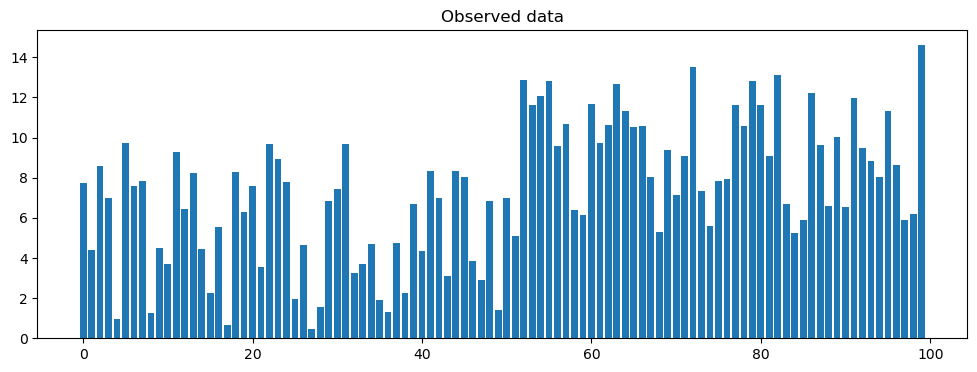

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 5 seconds.


In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm

plt.rcParams['figure.figsize'] = (12, 4)
rng = np.random.default_rng(seed=42)

data = np.concatenate([
    rng.uniform(low=0, high=10, size=50),
    rng.uniform(low=5, high=15, size=50)
])

n = len(data)
plt.bar(np.arange(n), data)
plt.title('Observed data')
plt.show()

with pm.Model() as model:
    alpha = 1.0 / data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)

    idx = np.arange(n)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=data)

    step = pm.NUTS()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

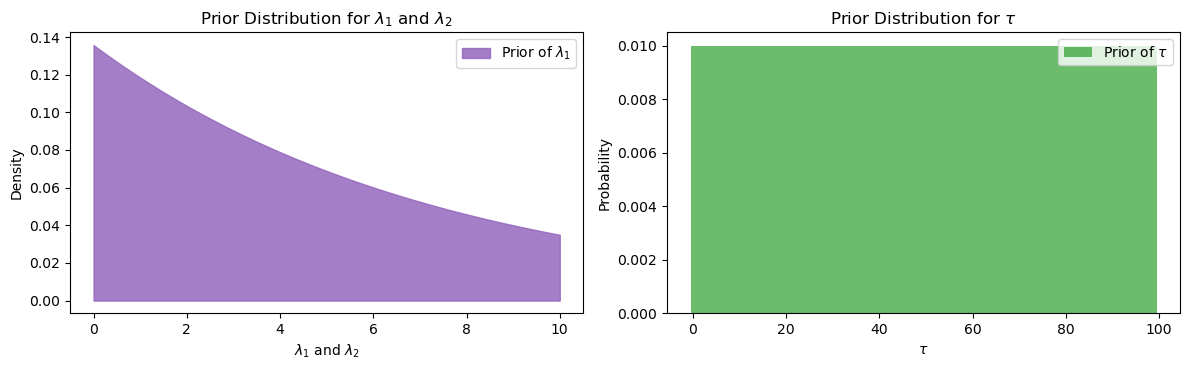

In [104]:
# Create a new figure for prior distributions
fig_prior, axes_prior = plt.subplots(1, 2)

x_values = np.linspace(0, 10, 100)
prior_lambda_1 = (alpha * np.exp(-alpha * x_values))  # Prior distribution for lambda_1
prior_lambda_2 = (alpha * np.exp(-alpha * x_values))  # Prior distribution for lambda_2

# Plot prior for lambda_1
axes_prior[0].fill_between(x_values, prior_lambda_1, color="C4", alpha=0.85, label="Prior of $\\lambda_1$")
axes_prior[0].set_title("Prior Distribution for $\\lambda_1$ and $\\lambda_2$")
axes_prior[0].set_xlabel("$\\lambda_1$ and $\\lambda_2$")
axes_prior[0].set_ylabel("Density")
axes_prior[0].legend()

# Plot prior for tau
tau_x_values = np.arange(0, n)  # Discrete values for tau
prior_tau = np.ones_like(tau_x_values) / len(tau_x_values)  # Uniform distribution
axes_prior[1].bar(tau_x_values, prior_tau, width=1, label="Prior of $\\tau$", color="C2", alpha=0.7)
axes_prior[1].set_title("Prior Distribution for $\\tau$")
axes_prior[1].set_xlabel("$\\tau$")
axes_prior[1].set_ylabel("Probability")
axes_prior[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

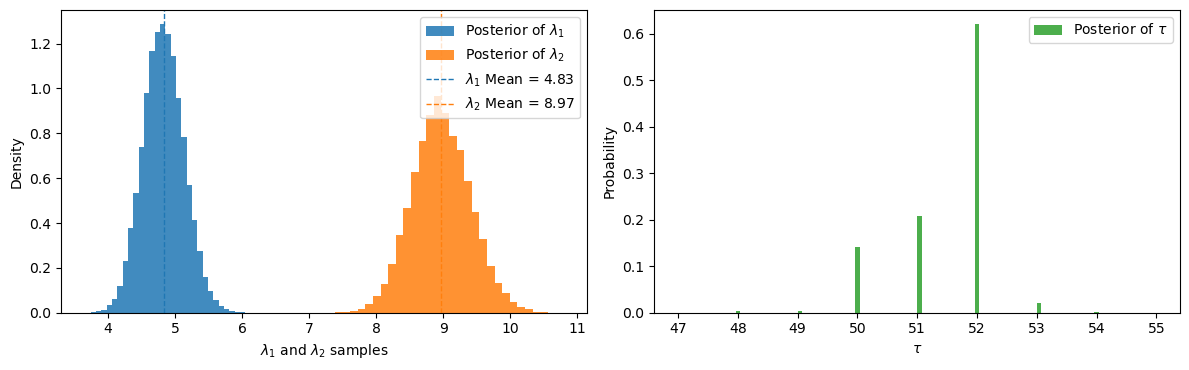

In [106]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
             label="Posterior of $\\lambda_1$", color="C0", density=True)
axes[0].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
             label="Posterior of $\\lambda_2$", color="C1", density=True)
axes[0].axvline(x=lambda_1_samples.mean(), color='C0', linestyle='--', linewidth=1,
                label=f'$\\lambda_1$ Mean = {lambda_1_samples.mean():0.2f}')
axes[0].axvline(x=lambda_2_samples.mean(), color='C1', linestyle='--', linewidth=1, 
                label=f'$\\lambda_2$ Mean = {lambda_2_samples.mean():0.2f}')
axes[0].set_xlabel("$\\lambda_1$ and $\\lambda_2$ samples")
axes[0].set_ylabel("Density")
axes[0].legend(loc="upper right")

axes[1].hist(tau_samples, bins=n, alpha=0.85,
             label=r"Posterior of $\tau$", color="C2", 
             rwidth=0.9, weights=np.ones_like(tau_samples) / tau_samples.shape[0])
axes[1].legend(loc="upper right")
axes[1].set_xlabel(r"$\tau$")
axes[1].set_ylabel("Probability")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [110]:
(lambda_2_samples-lambda_1_samples).mean()

4.138444109911759